In [178]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import itertools

import copy
random.seed(10)

In [179]:
img_dir = '/Users/ida/Google Drive/Big Data Econometrics/Slides/images/'

In [180]:
def fn_generate_cov(dim,corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar,corr)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()
    
def fn_group_to_ind(vecG,n_g):
    """
    Transform group effects vector of length G into an n-length individual effects vector 
    """
#     g = len(vecG)
#     return np.concatenate([np.concatenate([vecG[g] for i in range(n_g)]) for g in range(G)]).\
#     reshape([n,1])
    return np.array(list(itertools.chain.from_iterable(itertools.repeat(x,n_g) for x in vecG)))

def fn_ind_to_panel(vec,T):
    """
    Transform (n x 1) vector of individual specific effect to an (n x T) matrix
    """
    return np.concatenate([vec for i in range(T)],axis =1)

def fn_mat_wide_to_long(mat,n,T):
    """
    Take (n x T) matrix and output nxT vector with observations for each t stacked on top
    """
    return np.concatenate([mat[:,i] for i in range(T)]).reshape([n*T,1])

def fn_create_wide_to_long_df(data,colnames,n,G,T):
    """
    Take list of matrices in wide format and output a dataframe in long format
    """
    n_g = n/G # number of observations in each group
    if n_g.is_integer()==False:
        print('Error: n_g is not an integer')
    else:
        n_g = int(n_g)
    group = np.concatenate([fn_group_to_ind(np.array(range(G)).reshape([G,1]),n_g) for i in range(T)])
    if len(data)!=len(colnames):
        print('Error: number of column names not equal to number of variables')
    dataDict = {}
    for i in range(len(colnames)):
        dataDict[colnames[i]] = fn_mat_wide_to_long(data[i],n,T)[:,0]

    dataDict['group'] = group[:,0]+1
    dataDict['n'] = 1+np.concatenate([range(n) for i in range(T)])
    dataDict['t'] = 1+np.array(list(itertools.chain.from_iterable(itertools.repeat(i,n) for i in range(T))))
    return pd.DataFrame(dataDict)

# def fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend = False):
#     n_g = n/G # number of observations in each group
#     if n_g.is_integer()==False:
#         print('Error: n_g is not an integer')
#     else:
#         n_g = int(n_g)

#     alphaG = np.random.normal(1,1,[G,1]) # (G x 1) group fixed effects
#     alpha_i = fn_group_to_ind(alphaG,n_g) # (n x 1)
#     treatG = np.zeros([G,1])
#     treatG[:n_treated,] = 1
#     treat_i = fn_group_to_ind(treatG,n_g) # (n x 1)
#     # convert to (n X T)
#     if linear_trend==True:
#         gamma = np.vstack([np.array(range(T)) for i in range(n)])
#     else:
#         gamma = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T) # time specific effects   
#     alpha = fn_ind_to_panel(alpha_i,T)
#     treat = fn_ind_to_panel(treat_i,T)
#     treat = np.concatenate([0*treat[:,:treat_start],treat[:,treat_start:]],axis = 1)
    
#     sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
#     eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
#     X = np.concatenate([fn_generate_multnorm(n,.5,1) for i in range(T)],axis =1) # (n x T)
#     Y = alpha + gamma + beta*treat + delta*X+eps
    
#     return [Y,alpha,gamma,treat,X]

def fn_plot_dd(dfg,treat_start,fig_name=False):
    """
    Plot average outcome Y by group
    """
    
    Yg = dfg[['Y','I','group','t']].groupby(['group','t']).mean().reset_index()
    treatStatus = dict(zip(Yg[Yg.t==Yg.t.max()]['group'],Yg[Yg.t==Yg.t.max()]['I']))
    fig = plt.figure(figsize = (10,6))
    for g in Yg.group.unique():
        plt.plot(Yg[Yg.group==g]['t'],Yg[Yg.group==g]['Y'],label = 'treatment={}'.format(int(treatStatus[g])))
    plt.axvline(x=treat_start+1,color = 'red')
    plt.xlabel('time period')
    plt.ylabel('outcome')
    plt.legend()
    if fig_name:
        plt.savefig(img_dir + 'dd1.png')
        
def fn_within_transformation(dfg,varlist,group_var):
    """
    Transform each variable in the varlist using the within transformation to eliminate
    the group-fixed effects
    """
    dfm = dfg[varlist+[group_var]].groupby([group_var]).mean().\
                reset_index().\
                rename(columns = {k:'{}_bar'.format(k) for k in varlist})
    dfg = dfg.merge(dfm, on = ['group'],how = 'left')
    dfg['const'] = 1
    for v in varlist:
        dfg['{}_w'.format(v)] = dfg[v] - dfg['{}_bar'.format(v)]
    return dfg

Statsmodels sandwich variance estimators
https://github.com/statsmodels/statsmodels/blob/master/statsmodels/stats/sandwich_covariance.py

## 1. Generate data

$Y_{it} = W_{it}\tau_{it}+\mu_i+\delta_t+\varepsilon_{it}$

$\varepsilon_{it}^{\left(  r\right)  }/\sigma_{i}\sim IID\left[\chi^{2}(2)-2\right]  /2$

$\sigma_{i}^{2}\sim IID\left[  \chi^{2}(2)/4+0.5\right]$ 

In [181]:
# def fn_randomize_treatment(N,p=0.5):
N = 11
p = .5
treated = random.sample(range(N), round(N*p))
# 

treated



[9, 0, 6, 7, 4, 10]

In [182]:
l1 = list(range(10))
l1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [183]:
%%timeit
# add 2 to every element
l2 = []
for el in range(len(l1)):
    l2 = l2 + [el+2]
l2

1.23 µs ± 90.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [184]:
%%timeit
[(i+2) for i in l1]

525 ns ± 5.34 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [185]:
np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [248]:
n = 1000
T = 2
t_treat = 2# first treatment period
p = 0.5
tau = 2
mu = np.random.normal(1,1,[n,1]) # (n x 1)
sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
# eps = np.random.normal([n,T])
delta = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T)
treat = fn_randomize_treatment(n,p) # (n x 1)
W = np.concatenate([np.zeros([n,t_treat-1]),treat*np.ones([n,T-t_treat+1])],axis = 1)
Y = W*tau+mu+delta+eps
Y.shape

(1000, 2)

In [249]:
# constant, treatment dummy, time period = 2 dummy , interaction of those 2 dummies
vecY = np.concatenate([Y[:,0],Y[:,1]]).reshape(2000,1)
vecW = np.concatenate([W[:,0],W[:,1]]).reshape(2000,1)
vecT = np.concatenate([np.zeros([n,1]),np.ones([n,1])])
vecInt = vecW*vecT
vecConst = np.ones([2000,1])xvars = np.hstack([vecConst,vecW,vecT,vecInt])
mod = sm.OLS(vecY,xvars)
res = mod.fit()
print(res.summary())

(2000, 4)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     242.9
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           3.68e-95
Time:                        16:53:15   Log-Likelihood:                -3549.5
No. Observations:                2000   AIC:                             7105.
Df Residuals:                    1997   BIC:                             7122.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6274      0.045     13.889      0.0

In [67]:
Yt

array([[2.07832488, 1.68320036],
       [3.45006643, 1.64195153],
       [3.85554136, 2.00972155],
       [3.49435427, 1.76502504],
       [2.33965988, 0.87416435]])

In [189]:

Yt = Y[np.where(treat==1)[0],:] #select rows where the corresponding row in treat = 1
Yc = Y[np.where(treat==0)[0],:]
Yt.shape, Yc.shape

((500, 2), (500, 2))

Text(0.5, 1.0, 'Distribution of errors')

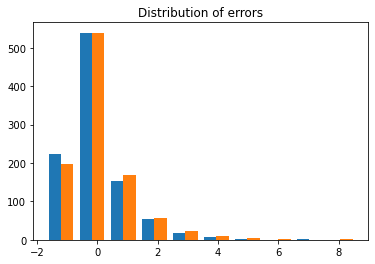

In [190]:
plt.hist(eps)
plt.title('Distribution of errors')

Estimate parameter of interest by running a regression of $\Delta Y_{i1}$ on the treatment indicator and an intercept

In [191]:
Ydiff = Y[:,1]-Y[:,0]
Wmod = copy.deepcopy(W)
Wmod[:,0] = 1
model = sm.OLS(Ydiff,Wmod)

In [192]:
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     487.3
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           2.96e-88
Time:                        13:40:23   Log-Likelihood:                -1780.2
No. Observations:                1000   AIC:                             3564.
Df Residuals:                     998   BIC:                             3574.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5229      0.064     -8.140      0.000      -0.649      -0.397
x1             2.0057      0.091     22.075      0.000       1.827       2.184
==============================================================================
Omnibus:                      138.012   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              959.762
Skew:                           0.403   Prob(JB):                    3.89e-209
Kurtosis:                       7.731   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$Y_{i1} - Y_{i0} = \mu_i + ....... - (\mu_i + .......)$

In [193]:
Yt_diff = np.mean(Yt[:,1])-np.mean(Yt[:,0]) # eliminates mu_i
Yc_diff = np.mean(Yc[:,1])-np.mean(Yc[:,0]) # eliminates mu_i
Yt_diff - Yc_diff # eliminates the delta_t

2.0056559437520955

In [194]:
v_Y = np.concatenate([Y[:,i] for i in range(T)]).reshape([2*n,1])
# v_W = np.concatenate([W[:,i] for i in range(T)]).reshape([2*n,1])
v_W = np.concatenate([W[:,1] for i in range(T)]).reshape([2*n,1])
v_mu = np.concatenate([mu for i in range(T)])
v_n = np.concatenate([range(1,n+1) for i in range(T)]).reshape([2*n,1])
v_t = np.concatenate([i*np.ones([n,1]) for i in range(1,T+1)])

In [195]:
df = pd.DataFrame({'y':v_Y[:,0],
                   'W':v_W[:,0],
                   'mu':v_mu[:,0],
                   'n':v_n[:,0],
                   't':v_t[:,0]})

Now let $T_i = 1$ if $t=2$ and $T_i=0$ otherwise and run regression

$Y_i = \alpha+W_{i1}+T_i+W_{i1}*T_i$

In [196]:
df['Ti'] = 1*(df.t==2)
df['const'] = 1
df['int'] = df.W*df.Ti

In [197]:
mod = sm.OLS(df.y,df[['const','W','Ti','int']])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     179.4
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          5.26e-103
Time:                        13:40:24   Log-Likelihood:                -3550.4
No. Observations:                2000   AIC:                             7109.
Df Residuals:                    1996   BIC:                             7131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6379      0.064      9.978      0.000       0.512       0.763
W             -0.0210      0.090     -0.232      0.816      -0.198       0.156
Ti            -0.5229      0.090     -5.785      0.000      -0.700      -0.346
int            2.0057      0.128     15.687      0.000       1.755       2.256
==============================================================================
Omnibus:                      295.177   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.857
Skew:                           0.831   Prob(JB):                    2.38e-153
Kurtosis:                       5.381   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Let's focus on the more interesting case where we observe multiple time periods and multiple groups

$Y_{igt} = \alpha_g+\gamma_t+\beta I_{gt}+\delta X_{igt}+\varepsilon_{igt}$

Assessing DD identification the key identifying assumption in DD models is that the treatment states/groups (g) have similar trends to the control states in the absence of treatment

In [198]:
def fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend = False,corr = False):
    n_g = n/G # number of observations in each group
    if n_g.is_integer()==False:
        return print('Error: n_g is not an integer')

    else:
        n_g = int(n_g)

        alphaG = np.random.normal(1,1,[G,1]) # (G x 1) group fixed effects
        alpha_i = fn_group_to_ind(alphaG,n_g) # (n x 1)
        treatG = np.zeros([G,1])
        treatG[:n_treated,] = 1
        treat_i = fn_group_to_ind(treatG,n_g) # (n x 1)
        # convert to (n X T)
        if linear_trend==True:
            gamma = np.vstack([np.array(range(T)) for i in range(n)])
        else:
            gamma = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T) # time specific effects   
        alpha = fn_ind_to_panel(alpha_i,T)
        treat = fn_ind_to_panel(treat_i,T)
        treat = np.concatenate([0*treat[:,:treat_start],treat[:,treat_start:]],axis = 1)

        sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
        eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)
        
        if corr == True:
            rho = .7
            u = np.zeros(eps.shape)
            u[:,0] = eps[:,0]
            for t in range(1,T):
                u[:,t] = rho*u[:,t-1]+eps[:,t]
                
        X = np.concatenate([fn_generate_multnorm(n,.5,1) for i in range(T)],axis =1) # (n x T)
        if corr == False:
            Y = alpha + gamma + beta*treat + delta*X+eps
        else:
            Y = alpha + gamma + beta*treat + delta*X + u

        return [Y,alpha,gamma,treat,X]

In [199]:
# def fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend = False,corr = False):

n = 10
G = 2
T = 5
n_treated = 1
treat_start = 4
beta = 1
delta = .5
linear_trend = True

n_g = n/G # number of observations in each group
if n_g.is_integer()==False:
    print('Error: n_g is not an integer')


In [200]:
n_g = int(n_g)

alphaG = np.random.normal(1,1,[G,1]) # (G x 1) group fixed effects
alpha_i = fn_group_to_ind(alphaG,n_g) # (n x 1)

In [201]:
treatG = np.zeros([G,1])
treatG[:n_treated,] = 1
treat_i = fn_group_to_ind(treatG,n_g) # (n x 1)

In [202]:
treat_i,treatG

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[1.],
        [0.]]))

In [203]:
gamma = np.ones([n,1])*np.random.normal(0,1,[1,T])
gamma

array([[ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079],
       [ 0.53272734,  0.51828703, -0.48633918, -1.74128078, -2.98146079]])

Serially corellated errors:

$u_t = \rho*u_{t-1}+e_t$

In [204]:

# convert to (n X T)
if linear_trend==True:
    gamma = np.vstack([np.array(range(T)) for i in range(n)])
else:
    gamma = np.ones([n,1])*np.random.normal(0,1,[1,T]) # (n x T) # time specific effects   
alpha = fn_ind_to_panel(alpha_i,T)
treat = fn_ind_to_panel(treat_i,T)
treat = np.concatenate([0*treat[:,:treat_start],treat[:,treat_start:]],axis = 1)

sig = (np.random.chisquare(2,[n,1])/4+0.5)**(1/2)
eps = sig*((np.random.chisquare(2,[n,T])-2)*0.5) # (n x T)

if corr == True:
    rho = .7
    u = np.zeros(eps.shape)
    u[:,0] = eps[:,0]
    for t in range(1,T):
        u[:,t] = rho*u[:,t-1]+eps[:,t]
X = np.concatenate([fn_generate_multnorm(n,.5,1) for i in range(T)],axis =1) # (n x T)



In [205]:
alpha.shape, gamma.shape, treat.shape

((10, 5), (10, 5), (10, 5))

In [206]:
treat

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [207]:





if corr == False:
    Y = alpha + gamma + beta*treat + delta*X+eps
else:
    Y = alpha + gamma + beta*treat + delta*X + u

return [Y,alpha,gamma,treat,X]

SyntaxError: 'return' outside function (<ipython-input-207-64a684190739>, line 6)

$Y_{igt} = \alpha_g+\gamma_t+\beta I_{gt}+\delta X_{igt}+\varepsilon_{igt}$

Within transformation to get rid of $\alpha_g$:

$Y_{igt} - \bar{Y}_{gt}$



In [208]:
n = 2 # 2 units and 1 unit is in each group
G = 2
n_treated = 1
T = 20

beta = 20
delta = 1
treat_start = 10 # when treatment starts

Plot the outcome for the treatment and control group

In [209]:
linear_trend = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)

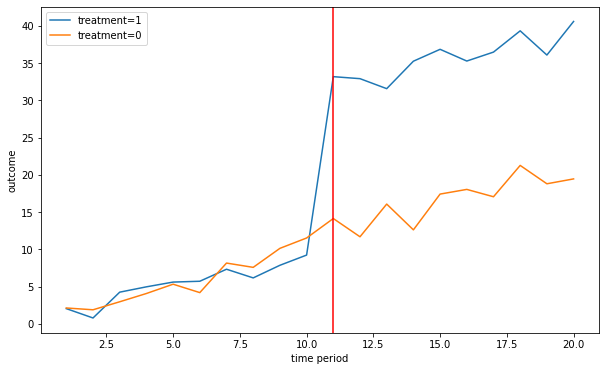

In [210]:
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

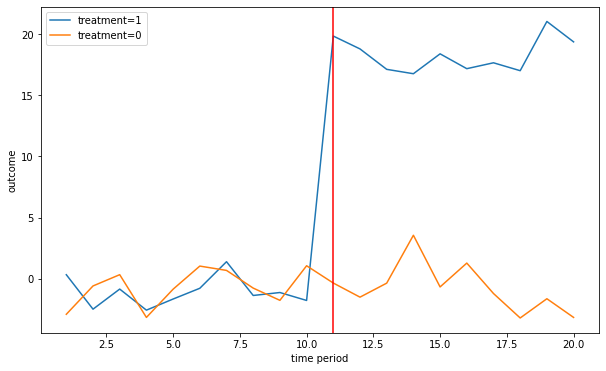

In [211]:
linear_trend = False
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

### Estimation

In [212]:
data = [Y,alpha,gamma,treat,X]
colnames = ['Y','alpha','gamma','I','X']

dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)

dfg = fn_within_transformation(dfg,colnames,'group')   

In [213]:
dfg.head()

,Y,alpha,gamma,I,X,group,n,t,Y_bar,alpha_bar,gamma_bar,I_bar,X_bar,const,Y_w,alpha_w,gamma_w,I_w,X_w
0,0.319496,-0.895547,-0.546378,0.0,1.377812,1,1,1,8.615999,-0.895547,-0.162203,0.5,-0.15752,1,-8.296503,-2.220446e-16,-0.384175,-0.5,1.535332
1,-2.919256,-0.286708,-0.546378,0.0,-1.078144,2,2,1,-0.720491,-0.286708,-0.162203,0.0,-0.04039,1,-2.198765,-1.110223e-16,-0.384175,0.0,-1.037754
2,-2.500770,-0.895547,-0.513985,0.0,0.332036,1,1,2,8.615999,-0.895547,-0.162203,0.5,-0.15752,1,-11.116769,-2.220446e-16,-0.351782,-0.5,0.489555
3,-0.600016,-0.286708,-0.513985,0.0,1.036672,2,2,2,-0.720491,-0.286708,-0.162203,0.0,-0.04039,1,0.120474,-1.110223e-16,-0.351782,0.0,1.077062
4,-0.856377,-0.895547,1.264813,0.0,-0.665249,1,1,3,8.615999,-0.895547,-0.162203,0.5,-0.15752,1,-9.472376,-2.220446e-16,1.427016,-0.5,-0.507730


#### Estimation using a full set of time and group dummies

In [214]:
# pd.get_dummies(dfg.group)

In [215]:
xvars = pd.concat([dfg[['I','X']],
                   pd.get_dummies(dfg['group'],drop_first = False),
                   pd.get_dummies(dfg['t'],drop_first = False)],axis = 1)
mod = sm.OLS(dfg['Y'],xvars)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     93.89
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           1.06e-13
Time:                        13:40:33   Log-Likelihood:                -45.914
No. Observations:                  40   AIC:                             137.8
Df Residuals:                      17   BIC:                             176.7
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I             20.4001      0.767     26.582      0.000      18.781      22.019
X              1.2694      0.277      4.576      0.000       0.684       1.855
1             -1.2907      0.436     -2.959      0.009      -2.211      -0.370
2             -0.5759      0.251     -2.296      0.035      -1.105      -0.047
1             -0.5568      0.824     -0.676      0.508      -2.295       1.182
2             -1.4858      0.841     -1.767      0.095      -3.260       0.288
3              1.1783      0.834      1.412      0.176      -0.582       2.939
4             -0.1733      0.920     -0.189      0.853      -2.113       1.767
5             -1.3141      0.846     -1.554      0.139      -3.099       0.471
6              1.8082      0.845      2.141      0.047       0.026       3.590
7              1.6278      0.825      1.972      0.065      -0.113       3.369
8             -0.1100      0.824     -0.134      0.895      -1.849       1.629
9             -0.6017      0.824     -0.730      0.475      -2.339       1.136
10             0.5768      0.824      0.700      0.493      -1.162       2.315
11             0.4581      0.836      0.548      0.591      -1.305       2.221
12             0.2653      0.839      0.316      0.756      -1.505       2.035
13            -0.1689      0.835     -0.202      0.842      -1.930       1.592
14             1.6129      0.835      1.932      0.070      -0.148       3.374
15            -0.8069      0.848     -0.951      0.355      -2.596       0.983
16             1.4182      0.864      1.641      0.119      -0.405       3.242
17            -0.6037      0.831     -0.726      0.478      -2.358       1.150
18            -2.1873      0.832     -2.628      0.018      -3.943      -0.431
19            -1.4659      0.968     -1.514      0.148      -3.509       0.577
20            -1.3379      0.840     -1.593      0.130      -3.109       0.434
==============================================================================
Omnibus:                        4.798   Durbin-Watson:                   2.930
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.432
Skew:                           0.000   Prob(JB):                       0.0661
Kurtosis:                       4.805   Cond. No.                     2.05e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.41e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Estimation using a within group transformation

_w denotes variables that come out of the within transformation

In [216]:
xvars = pd.concat([dfg[['I_w','X_w']],
                  pd.get_dummies(dfg['t'])],axis = 1)
mod = sm.OLS(dfg['Y_w'],xvars)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Y_w   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     72.02
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           2.62e-13
Time:                        13:40:34   Log-Likelihood:                -45.914
No. Observations:                  40   AIC:                             135.8
Df Residuals:                      18   BIC:                             173.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I_w           20.4001      0.746     27.352      0.000      18.833      21.967
X_w            1.2694      0.270      4.709      0.000       0.703       1.836
1             -0.4634      0.824     -0.563      0.581      -2.194       1.267
2             -1.3925      0.839     -1.659      0.114      -3.156       0.371
3              1.2716      0.834      1.525      0.145      -0.481       3.024
4             -0.0800      0.915     -0.087      0.931      -2.003       1.843
5             -1.2208      0.844     -1.446      0.165      -2.994       0.553
6              1.9015      0.844      2.253      0.037       0.129       3.674
7              1.7212      0.825      2.086      0.051      -0.012       3.455
8             -0.0167      0.824     -0.020      0.984      -1.748       1.715
9             -0.5083      0.824     -0.617      0.545      -2.239       1.222
10             0.6701      0.824      0.813      0.427      -1.061       2.401
11             0.5514      0.828      0.666      0.514      -1.187       2.290
12             0.3586      0.831      0.431      0.671      -1.388       2.105
13            -0.0755      0.827     -0.091      0.928      -1.813       1.662
14             1.7062      0.827      2.063      0.054      -0.031       3.444
15            -0.7136      0.839     -0.850      0.406      -2.477       1.050
16             1.5116      0.856      1.766      0.094      -0.286       3.310
17            -0.5103      0.824     -0.619      0.543      -2.241       1.220
18            -2.0940      0.825     -2.540      0.021      -3.826      -0.362
19            -1.3726      0.954     -1.439      0.167      -3.376       0.631
20            -1.2445      0.831     -1.497      0.152      -2.991       0.502
==============================================================================
Omnibus:                        4.798   Durbin-Watson:                   2.930
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.432
Skew:                           0.000   Prob(JB):                       0.0661
Kurtosis:                       4.805   Cond. No.                         7.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multiple groups and time periods

$Y_{igt} = \alpha_g+\gamma_t+\beta I_{gt}+\delta X_{igt}+\varepsilon_{igt}$


In [217]:
n = 1000
G = 10
n_treated = 5
T = 20

beta = 20
delta = 1
treat_start = 10


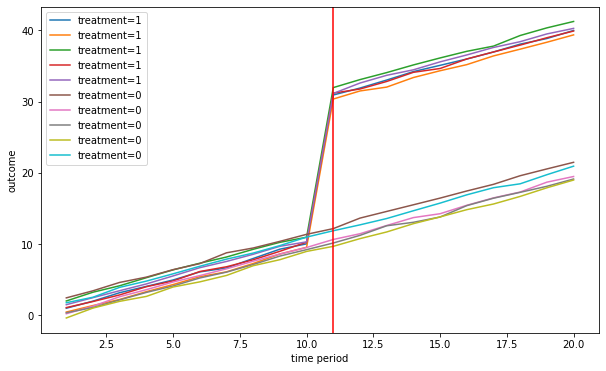

In [218]:
linear_trend = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]
dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)
# dfg.head()

### Estimation


In [219]:
dfw = fn_within_transformation(dfg,colnames,'group')   

In [220]:
xvars = pd.concat([dfw[['I_w','X_w']],
                  pd.get_dummies(dfw['t'])],axis = 1)
mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
res = mod.fit(cov_type='HC1')
t = res.params.I_w/res.HC1_se.I_w

In [221]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Y_w   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 08 Feb 2021   Prob (F-statistic):                nan
Time:                        13:40:36   Log-Likelihood:                -28192.
No. Observations:               20000   AIC:                         5.643e+04
Df Residuals:                   19978   BIC:                         5.660e+04
Df Model:                          21                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I_w           19.9867      0.028    712.870      0.000      19.932      20.042
X_w            0.9981      0.007    147.009      0.000       0.985       1.011
1             -9.5285      0.032   -294.481      0.000      -9.592      -9.465
2             -8.5477      0.031   -278.041      0.000      -8.608      -8.487
3             -7.4749      0.032   -233.314      0.000      -7.538      -7.412
4             -6.5301      0.031   -213.574      0.000      -6.590      -6.470
5             -5.5166      0.031   -178.651      0.000      -5.577      -5.456
6             -4.4325      0.034   -130.609      0.000      -4.499      -4.366
7             -3.5591      0.030   -116.873      0.000      -3.619      -3.499
8             -2.5156      0.032    -77.789      0.000      -2.579      -2.452
9             -1.4233      0.034    -41.344      0.000      -1.491      -1.356
10            -0.4743      0.032    -14.866      0.000      -0.537      -0.412
11             0.4865      0.032     15.107      0.000       0.423       0.550
12             1.5096      0.033     46.048      0.000       1.445       1.574
13             2.4724      0.031     78.889      0.000       2.411       2.534
14             3.5285      0.031    112.952      0.000       3.467       3.590
15             4.4621      0.030    148.465      0.000       4.403       4.521
16             5.5001      0.032    170.856      0.000       5.437       5.563
17             6.5112      0.032    204.902      0.000       6.449       6.574
18             7.5147      0.035    215.853      0.000       7.446       7.583
19             8.4975      0.034    246.447      0.000       8.430       8.565
20             9.5200      0.031    308.540      0.000       9.460       9.580
==============================================================================
Omnibus:                     9425.670   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68273.339
Skew:                           2.146   Prob(JB):                         0.00
Kurtosis:                      10.969   Cond. No.                         7.40
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Simulate placebo policy

In [222]:
def fn_placebo_treatment(row,tstart,treated):
    if (row.t>=tstart) & (row.group in treated):
        return 1
    else:
        return 0

### THIS IS THE PART WE DIDN'T COVER IN LECTURE 4
What the code below does is to simulate a placebo policy - where we mistakenly treat some units as being assigned a treatment even though they're not and we estiamte the treatment effect
We expect to reject the null hypothesis that the treatment effect is different from 0 a low % of the time because the treatment effect doesn't exist so it is zero!
Indeed, we reject the null around 1% of the time below. With more replications it should converge to 5%.

In [223]:
R = 100
l = []
n = 1000
G = 10
n_treated = 0
T = 20

beta = 20
delta = 1
treat_start = 10
linear_trend = True
colnames = ['Y','alpha','gamma','I','X']

for r in tqdm(range(R)):
    np.random.seed(r)
    [Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend)
    data = [Y,alpha,gamma,treat,X]
    dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
    tstart = random.choice(range(dfg.t.min(),dfg.t.max()+1)) # treatment start date
    treated = random.choices(range(dfg.group.min(),dfg.group.max()+1),k = int(dfg.group.max()/2))
    dfg['I'] = dfg.apply(lambda row: fn_placebo_treatment(row,tstart,treated),axis = 1)
    dfw = fn_within_transformation(dfg,colnames,'group')  
    xvars = pd.concat([dfw[['I_w','X_w']],
                  pd.get_dummies(dfw['t'])],axis = 1)
    mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
    res = mod.fit(cov_type='HC1')
    t = res.params.I_w/res.HC1_se.I_w
    if np.abs(t)>1.96:
        l = l+[1]
    else:
        l = l+[0]

  6%|▌         | 6/100 [00:02<00:35,  2.61it/s]<ipython-input-223-02feb1c08ec8>:27: RuntimeWarning: invalid value encountered in double_scalars
  t = res.params.I_w/res.HC1_se.I_w
100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


In [177]:
np.mean(l) # we reject the null of a nonzero treatment effect 1% of the time

0.01

### Now let's add some serial correlation to the DGP

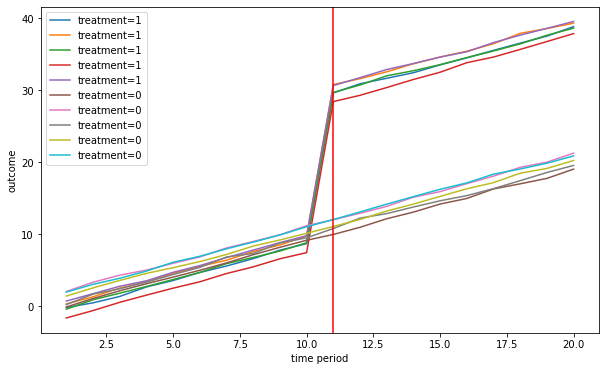

In [159]:
n = 1000
G = 10
n_treated = 5
T = 20

beta = 20
delta = 1
treat_start = 10

linear_trend = True
serial_corr = True
[Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend,serial_corr)
colnames = ['Y','alpha','gamma','I','X']
data = [Y,alpha,gamma,treat,X]
dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
fn_plot_dd(dfg,treat_start)

$y_{it}$

shock at time $t$ equal to $\gamma_t$

Estimate:

$y_{it}  = \alpha + \beta*\gamma_t+\varepsilon_{it}$

Obtain residuals $\hat{\varepsilon}_{it}$

In [160]:
def fn_run_mc(beta,R,corr):
    l0 = []
    l1 = []
    for r in tqdm(range(R)):
        np.random.seed(r)
        [Y,alpha,gamma,treat,X]= fn_generate_grouped_panel(n,G,T,n_treated,treat_start,beta,delta,linear_trend,corr)
        data = [Y,alpha,gamma,treat,X]
        dfg = fn_create_wide_to_long_df(data,colnames,n,G,T)
        tstart = random.choice(range(dfg.t.min(),dfg.t.max()+1))
        treated = random.choices(range(dfg.group.min(),dfg.group.max()+1),k = int(dfg.group.max()/2))
    #     dfg['I'] = dfg.apply(lambda row: fn_placebo_treatment(row,tstart,treated),axis = 1)
        dfw = fn_within_transformation(dfg,colnames,'group')  
        xvars = pd.concat([dfw[['I_w','X_w']],
                      pd.get_dummies(dfw['t'])],axis = 1)
        mod = sm.OLS(dfw['Y_w'],xvars,cluster= dfw['group'])
        res = mod.fit(cov_type='HC1')
        t0 = res.params.I_w/res.HC1_se.I_w # test H0: beta=0
        t1 = (res.params.I_w-beta)/res.HC1_se.I_w # test H0: beta = beta_true

        l0 = l0 + [1*(np.abs(t0)>1.96)]
        l1 = l1 + [1*(np.abs(t1)>1.96)]

    return np.mean(l0),np.mean(l1)

In [164]:
t_stat = .2
t_stat>1.96, 1*(t_stat>1.96)

(False, 0)

In [167]:
R = 500
n = 1000
G = 10
n_treated = 5
T = 20
delta = 1
treat_start = 10
linear_trend = True
colnames = ['Y','alpha','gamma','I','X']


##### Treatment effect = 2 with no serial correlation

In [168]:
beta = 2
corr = False

h1, hb = fn_run_mc(beta,R,corr)
h1,hb

100%|██████████| 500/500 [00:38<00:00, 13.04it/s]


(1.0, 0.066)

##### Treatment effect = 2 with serial correlation

In [98]:
beta = 2
corr = True

h1, hb = fn_run_mc(beta,R,corr)
h1,hb

100%|██████████| 500/500 [00:25<00:00, 19.81it/s]


(1.0, 0.34)

##### Treatment effect = 0, no serial correlation

In [99]:
beta = 0
corr = False

h1, hb = fn_run_mc(beta,R,corr)
print('We reject beta=0 {} of the time'.format(h1))

100%|██████████| 500/500 [00:27<00:00, 18.02it/s]

We reject beta=0 0.066% of the time


##### Treatment effect = 0, serial correlation

In [169]:
beta = 0
corr = True

h1, hb = fn_run_mc(beta,R,corr)
print('We reject beta=0 {} of the time'.format(h1))

100%|██████████| 500/500 [00:37<00:00, 13.47it/s]

We reject beta=0 0.34 of the time


## Sentsitivity tests

Redo the analysis on pre-event years - the estiamted treatment effect should be zero!
Are treatment and control gropus similar along observable dimensions?
Make sure the change is concentrated around the event
Make sure tha tother outcome variables that should be unaffected by the event are indeed unaffected